# **SHAP workflow for the best model (Random Forest)**

### For suitable deployment + UI explanations, I will be inculcating SHAP workflow for my best model 



In [224]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [225]:
df = pd.read_csv("../data/Nova_Features_Eng.csv")

# Print the top 5 rows
df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,fee_ratio,amount_velocity_interaction,device_ip_risk,new_device_velocity,amount_usd_capped,log_amount_usd,log_fee,new_device_high_velocity,young_account_high_amount,ip_location_risk
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.015277,0.0,0.064206,0,278.19,5.631893,1.658228,0,0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,WEB,208.51,154.29,4.24,...,0.027481,0.0,0.270275,0,154.29,5.045294,1.656321,0,0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,MOBILE,160.33,160.33,2.70,...,0.016840,0.0,0.410343,0,160.33,5.083452,1.308333,0,0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,MOBILE,59.41,59.41,2.22,...,0.037367,0.0,0.327294,0,59.41,4.101155,1.169381,0,0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,MOBILE,200.96,200.96,3.61,...,0.017964,0.0,0.108174,0,200.96,5.308070,1.528228,0,0,0


In [226]:
# Drop columns that should NOT be encoded
df.drop(columns=['transaction_id','customer_id', 'device_id', 'hour', 'ip_address', 'timestamp'], inplace=True)

### Split data

In [228]:
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Build preprocessing (handles object/categorical safely)

In [230]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

***Insight:***

SHAP needs the exact same transformation used in production.

This also prevents category-mismatch issues at inference time.

### Train the Random Forest in a Pipeline

In [233]:
fraud_weight = 3
class_weight = {0: 1.0, 1: fraud_weight}

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

***Insight:***
This ensures the deployed model receives raw inputs and transforms them consistently. Also, SHAP explanations can be mapped back to meaningful feature names (including one-hot features).

In [235]:
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

In [236]:
def evaluate_pipeline_model(model, X_test, y_test, threshold=0.5):

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    auc = roc_auc_score(y_test, y_prob)
    print("ROC-AUC:", round(auc, 4))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Fraud", "Fraud"],
        yticklabels=["Not Fraud", "Fraud"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0     0.9826    1.0000    0.9912      2029
           1     1.0000    0.8191    0.9006       199

    accuracy                         0.9838      2228
   macro avg     0.9913    0.9095    0.9459      2228
weighted avg     0.9841    0.9838    0.9831      2228

ROC-AUC: 0.9432


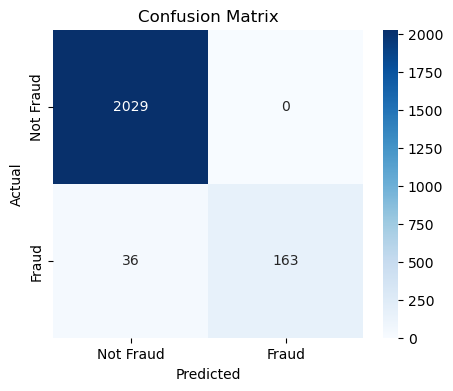

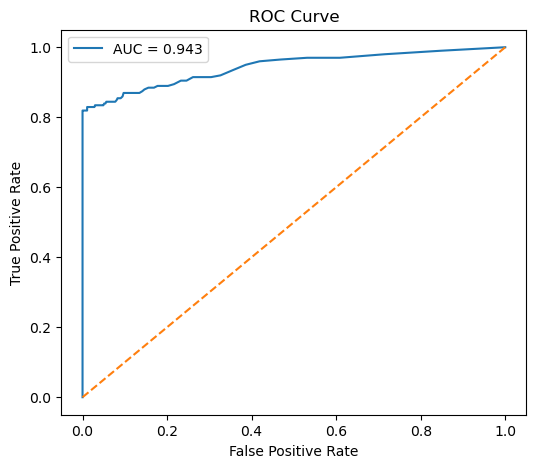

In [237]:
evaluate_pipeline_model(rf_pipe, X_test, y_test, threshold=0.5)

### Get the final feature names (so SHAP outputs are readable)

In [239]:
ohe = rf_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([cat_feature_names, np.array(num_cols)])

***Insight:*** SHAP returns values per transformed column. This step gives the exact names the model is actually using.

### Prepare transformed test set for SHAP

In [242]:
X_test_trans = rf_pipe.named_steps["preprocess"].transform(X_test)


***Insight:*** TreeExplainer needs the exact numeric matrix used by the tree model.

### Build the SHAP explainer (TreeExplainer for Random Forest)

In [245]:
explainer = shap.TreeExplainer(rf_pipe.named_steps["model"])


***Insight:*** TreeExplainer is the best/fastest/most accurate explainer for tree models

### Compute SHAP values (global + local explanations)

In [248]:
# For binary classification, shap_values is usually a list:
# shap_values[0] = class 0, shap_values[1] = class 1 (fraud)
shap_values = explainer(X_test_trans)


# I will use class 1 (fraud) explanations
shap_fraud = shap_values[1]
base_value = explainer.expected_value[1]

In [249]:
# shap_values.values has shape: (n_samples, n_features, n_classes)
shap_fraud = shap_values.values[:, :, 1]

In [250]:
print("SHAP shape:", shap_fraud.shape)
print("X_test_trans shape:", X_test_trans.shape)


SHAP shape: (2228, 89)
X_test_trans shape: (2228, 89)


### Global SHAP plots (what features matter overall)

#### 1. Summary (beeswarm) plot

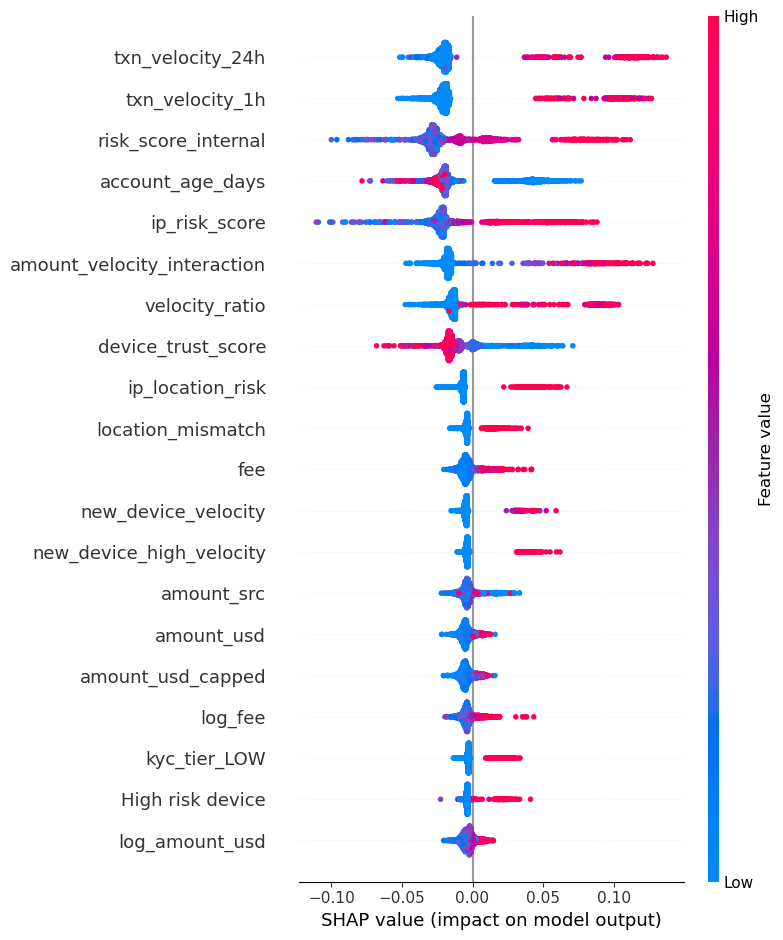

In [252]:
shap.summary_plot(
    shap_fraud,
    X_test_trans,
    feature_names=feature_names,
    show=True
)

***Insight:***
Top features across all transactions, and whether high/low values increase fraud risk.

#### 2. Bar plot (mean absolute impact)

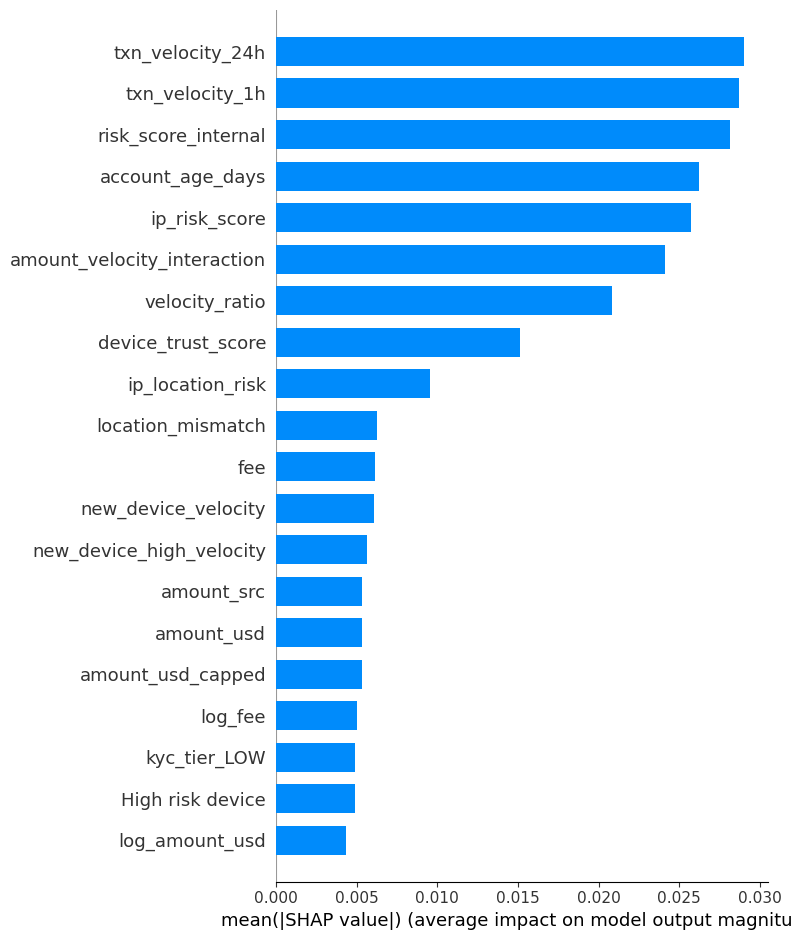

In [255]:
shap.summary_plot(
    shap_fraud,
    X_test_trans,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

***Insight:*** Ranked global importance (average absolute SHAP impact).

### Local explanation for one transaction (perfect for UI)

#### Pick one row from the test set:

In [258]:
i = 0  # index of the row to explain

x_row = X_test.iloc[[i]]
x_row_trans = rf_pipe.named_steps["preprocess"].transform(x_row)

In [259]:
# Using the NEW explainer call

row_shap_exp = explainer(x_row_trans)

In [260]:
# Extract fraud-class SHAP values

row_shap = row_shap_exp.values[0, :, 1]
base_value = row_shap_exp.base_values[0, 1]

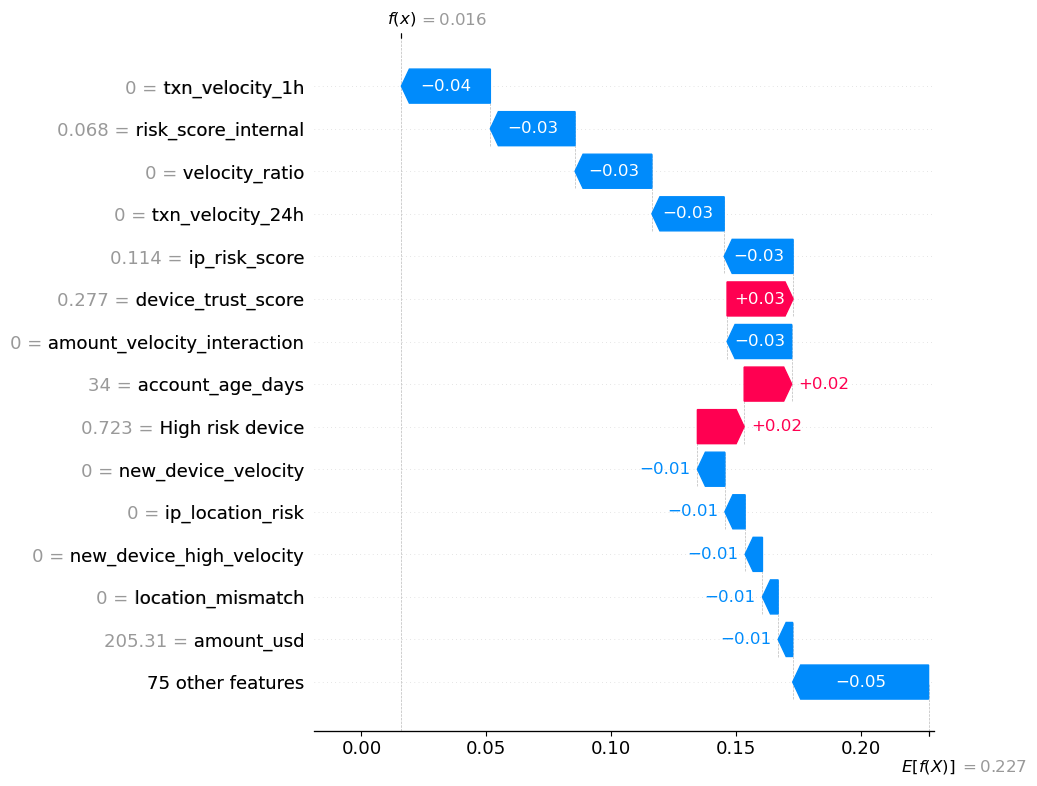

In [261]:
# Create the waterfall plot (UI-ready)


exp = shap.Explanation(
    values=row_shap,
    base_values=base_value,
    data=x_row_trans[0],
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)

***Insight:***

- Starts at the base fraud risk (baseline)

- Shows which features push the prediction up or down

- Great for a user-facing “reason codes” panel

### Convert SHAP to “top reasons” for your UI

#### This gives a clean structure like: feature → impact.

In [264]:
def shap_top_reasons_for_ui(
    rf_pipe,
    explainer,
    X_row,
    feature_names,
    top_k=8
):
    """
    Returns top SHAP reasons for fraud prediction (class 1)
    """

    # Transform input row exactly as the model sees it
    X_row_trans = rf_pipe.named_steps["preprocess"].transform(X_row)

    # NEW SHAP API
    exp = explainer(X_row_trans)

    # Extract SHAP values for fraud class (class index = 1)
    shap_vals = exp.values[0, :, 1]
    base_val = exp.base_values[0, 1]

    # Model predicted probability
    proba = rf_pipe.predict_proba(X_row)[0, 1]

    # Top contributing features
    idx = np.argsort(np.abs(shap_vals))[::-1][:top_k]

    reasons = [
        {
            "feature": feature_names[j],
            "shap_value": float(shap_vals[j])
        }
        for j in idx
    ]

    return {
        "fraud_probability": float(proba),
        "base_value": float(base_val),
        "top_reasons": reasons
    }

### Below is a production-ready way to translate raw SHAP output into clear, human-readable explanations

#### Strategy for human-readable SHAP explanations

##### These three things will be done:

✅ A. Clean feature names

Remove cat__, num__, one-hot noise

✅ B. Detect direction

shap_value > 0 → increases fraud risk

shap_value < 0 → decreases fraud risk

✅ C. Attach domain-specific explanations



### Step 1: Feature name cleaner

In [266]:
def clean_feature_name(raw_name):
    """
    Converts pipeline feature names into readable names
    """
    name = raw_name.replace("cat__", "").replace("num__", "")
    name = name.replace("_", " ")

    return name

### Step 2: Explanation templates

In [268]:
FEATURE_EXPLANATIONS = {
    "txn velocity 1h": "High number of transactions in the last hour",
    "txn velocity 24h": "High transaction activity in the last 24 hours",
    "velocity ratio": "Recent transaction spike compared to historical behavior",
    "ip risk score": "IP address is associated with high fraud risk",
    "device trust score": "Device has low trust history",
    "new device": "Transaction made from a new or unseen device",
    "amount usd": "Transaction amount is unusually high",
    "log amount usd": "Transaction amount deviates significantly from normal behavior",
    "fee ratio": "Transaction fee pattern is abnormal",
    "location mismatch": "IP location does not match expected user location",
    "kyc tier": "Low KYC verification level",
    "channel mobile": "Transaction performed via mobile channel",
    "channel web": "Transaction performed via web channel",
}

### Step 3: Convert SHAP reasons into readable text

In [270]:
def shap_reasons_to_text(ui_payload):
    explanations = []

    for item in ui_payload["top_reasons"]:
        raw_feature = item["feature"]
        shap_val = item["shap_value"]

        clean_name = clean_feature_name(raw_feature)

        # Direction
        if shap_val > 0:
            direction = "increased"
        else:
            direction = "reduced"

        # Explanation text
        base_text = FEATURE_EXPLANATIONS.get(
            clean_name,
            f"{clean_name.capitalize()} influenced the fraud score"
        )

        explanations.append({
            "feature": clean_name,
            "impact": direction,
            "strength": round(abs(shap_val), 3),
            "message": f"{base_text}, which {direction} the fraud risk."
        })

    return explanations

### Full UI-ready output

In [272]:
ui_payload = shap_top_reasons_for_ui(
    rf_pipe,
    explainer,
    X_test.iloc[[i]],
    feature_names,
    top_k=3
)

human_readable = shap_reasons_to_text(ui_payload)

human_readable

[{'feature': 'txn velocity 1h',
  'impact': 'reduced',
  'strength': 0.036,
  'message': 'High number of transactions in the last hour, which reduced the fraud risk.'},
 {'feature': 'risk score internal',
  'impact': 'reduced',
  'strength': 0.034,
  'message': 'Risk score internal influenced the fraud score, which reduced the fraud risk.'},
 {'feature': 'velocity ratio',
  'impact': 'reduced',
  'strength': 0.031,
  'message': 'Recent transaction spike compared to historical behavior, which reduced the fraud risk.'}]


### Save output for deployment (model + feature list)

In [274]:
joblib.dump(rf_pipe, "rf_fraud_pipeline.pkl")


['rf_fraud_pipeline.pkl']

Save the feature names used after preprocessing

In [276]:
pd.DataFrame({"feature_name": feature_names}).to_csv(
    "rf_shap_feature_names.csv",
    index=False
)